<div align=”center”>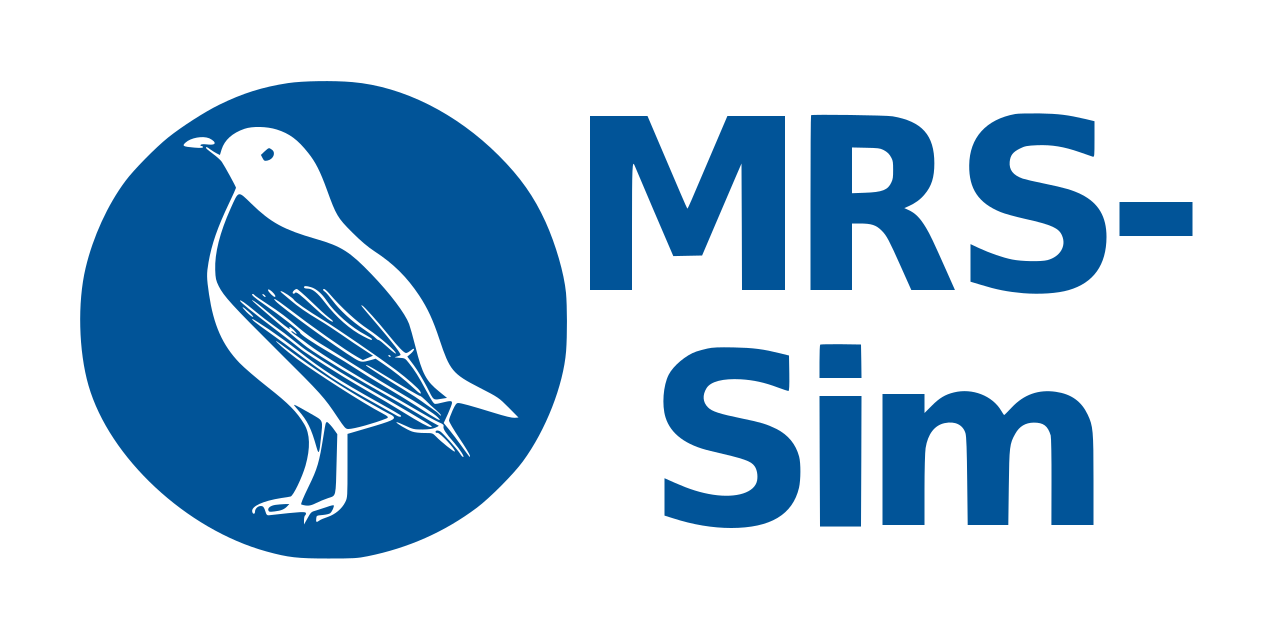</div>

- - - 

# Baseline & Residual Water Simulator

A single simulation protocol is used to generate the contributions for both baseline offset and residual water. By using different configuration dictionaries, it is possible to switch from very smooth, undulating baselines to rather erratic and rough residual water regions. The following code can be used to interacitvely study the effects different parameters have on the simulations.

This work uses a smoothed, pseudo-random bounded walk algorithm for the simulations. For simplicity, this will be referred to as a _(random) bounded walk_, or simply a _walk_, in the remainder of this notebook.

## Variables
These simulations use at least 9 degrees of freedom with several additional, but optional inputs: 
    1. Starting height (start),
    2. Ending height (end),
    3. Standard deviation of jumps (std), 
    4. Lower bound (lower),  
    5. Upper bound (upper), 
    6. Point density (pt_density), 
    7. PPM range (ppm_range), 
    8. Length of smoothing window (window), 
    9. Scale (scale), 
    10. Dropout probability (drop_prob), and
    11. \*Prime (prime).

Floats or integers can be provided for the point density, prime, and drop_prob. Everything else should be provided as a list with either a single value or a range in the form of \[min_range, max_range\]. When a single value is provided, that variable will be fixed. If a range is specified, then values will be sampled from that range uniformly. The point density and the PPM range are used to calculate the length of the walks. This length coupled with $std$ control the flexibility of raw simulation. The length of the smoothing window, $window$, will affect the smoothness of the resulting walk. It is specified as a fraction of the length of the walk, so that it is independent of walk length, and can also be either fixed or sampled. $scale$ determines how prominent each offset will be when added to the simulated data. $drop\_prob$ is used to randomly omit the offset from that percentage of the simulations. $prime$ \[units: ppm\] is used for generating the residual water regions. This allows the region to vary in length by sampling two values in the range of \[$-prime$,$prime$) that can expand, contract, or slightly offset the residual water region.


## Post-processing
Once the random walks have been generated, they are then smoothed with kernels of either fixed or varying width. At this point, the walks are normalized to [0,1] and then scaled down according to $scale$. Afterwards, trend lines are calculated between the starting and ending points which are then removed so that they start and end on the x-axis. A function called _sim2acquired_ then uses zero padding and a nonuniform interpolator to add tails to both sides of the walks so that they match the PPM range of basis set considering the spectral width and the carrier frequency. Before being added to the FIDs, they are multiplied by the maximum value of the FID in the frequency domain to scale them up to the correct order of magnitude. This makes $scale$ relative to the maximum height in the spectra. The offsets are added to the FIDs in the frequency domain before an inverser FFT returns the data to the time domain.

The parameters presented below control the length of the walks, their trend lines, flexibility, and smoothness. The default values presented in the config dictionaries were determined through preliminary experiments to closely approximate what was observed in a clinical dataset.

---

# Exploring the simulator

This chapter of the notebook is dedicated to exploring how the different parameters of the simulator affect the outputs. This is a useful way to familiarize yourself with this simulator and its behavior. Additionally, it can be used to identify the optimal parameters for your own simulations.

## Getting started

The first thing needed to get started are the imports. So you'll need to run the next two cells before proceeding.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from types import SimpleNamespace
import copy

from src.aux import (batch_linspace, batch_smooth, HilbertTransform, normalize, 
                     sample_baselines, sample_resWater, sim2acquired,
                     Fourier_Transform, inv_Fourier_Transform)
from src.baselines import bounded_random_walk
from src.interpolate import CubicHermiteMAkima as CubicHermiteInterp

## Configuration dictionaries

The following dictionaries are the standard defaults in MRS-Sim for generating baseline offsets and residual water contributions. To explore how the models output change with the different dictionaries, toggle between the two cfg options in the [section](#Preparing-for-the-simulations) below.

In [77]:
baseline_cfg = {
        "start":           [    -1,     1],
        "end":             [    -1,     1],
        "upper":           [            1],
        "lower":           [           -1],
        "std":             [  0.05,  0.20],
        "window":          [  0.15,   0.3],
        "pt_density":          128,
        "ppm_range":       [  -1.6,   8.5],
        "scale":           [     1,   1.0],
        "drop_prob":           0.0
}

resWater_cfg = {
        "start":           [            0],
        "end":             [            0],
        "upper":           [     0,     1],
        "lower":           [     0,     1],
        "std":             [   0.2,  0.40],
        "window":          [         0.10],
        "pt_density":         1204,
        "ppm_range":       [   4.4,   4.9],
        "prime":              0.15,
        "scale":           [   1.0,   1.0], # typically: [0.05, 0.20]. Increased for better visualization.
        "drop_prob":           0.0
}

## Defining the generator

The _generate()_ function below was adapted from the implementation in the code base. To further explore the simulator, addition intermediate steps are returned.

In [78]:
def generate(config: dict,
             ppm: torch.Tensor,
             ppm_cropped: torch.Tensor,
             trendlines: bool=False,
            ) -> tuple():
    '''
    Simulate baseline offsets
    '''
    cfg = SimpleNamespace(**config)
    
    # Perform the walk
    baselines = bounded_random_walk(cfg.start, cfg.end, 
                                    cfg.std, cfg.lower_bnd, 
                                    cfg.upper_bnd, 
                                    cfg.length)
    
    # Smooth the walk
    smoothed = batch_smooth(baselines, cfg.windows, 'constant')

    # Define the trend lines
    trend = batch_linspace(smoothed[...,0].unsqueeze(-1),
                           smoothed[...,-1].unsqueeze(-1), 
                           cfg.length)
    
    # Remove the trend lines
    baselines = baselines - trend
    smoothed  = smoothed  - trend

    # Normalize the data according to the unsmoothed baselines
    baselines, denom = normalize(signal=baselines, fid=False, denom=None,  noisy=-3)
    smoothed,  _     = normalize(signal=smoothed,  fid=False, denom=denom, noisy=-3)
    trend,     _     = normalize(signal=trend,     fid=False, denom=denom, noisy=-3)

    # Randomly omitting simulations. If drop_prob==0, then nothing happens.
    if cfg.rand_omit>0: 
        baselines, ind = rand_omit(baselines, 0.0, cfg.rand_omit)
        smoothed[ind,...].fill_(0.0)
        trend[ind,...].fill_(0.0)


    # Convert simulated baseline from local to clinical range before 
    # Hilbert transform makes the imaginary component. Then resample 
    # acquired range to cropped range.
    # Intermediate step: unsmoothed walk
    ppm_range = [torch.as_tensor(val).unsqueeze(-1) for val in cfg.ppm_range]
    raw_baseline = HilbertTransform(
                        sim2acquired(baselines * config['scale'], 
                                     [ppm_range[0], ppm_range[1]],
                                     ppm)
                   ) 
    ch_interp = CubicHermiteInterp(xaxis=ppm, signal=raw_baseline)
    baselines = ch_interp.interp(xs=ppm_cropped)
    
    # Intermediate step: smoothed walk
    raw_baseline = HilbertTransform(
                        sim2acquired(smoothed * config['scale'], 
                                     [ppm_range[0], ppm_range[1]],
                                     ppm)
                   ) 
    ch_interp = CubicHermiteInterp(xaxis=ppm, signal=raw_baseline)
    smoothed = ch_interp.interp(xs=ppm_cropped)
    
    # Intermediate step: trend line
    trend = HilbertTransform(
                        sim2acquired(trend * config['scale'], 
                                     [ppm_range[0], ppm_range[1]],
                                     ppm)
                   )

    if trendlines: 
        return baselines, smoothed, raw_baseline, trend
    
    return baselines, smoothed, raw_baseline

# Plotting the outputs for comparison
def plot(raw, smooth, std, wid_len, length, ppm, cropped=False):
    if isinstance(std, float): std = torch.as_tensor([std] * raw.shape[0])
    if isinstance(wid_len, float): wid_len = torch.as_tensor([wid_len] * raw.shape[0])
    rows = raw.shape[0] // 2 if raw.shape[0] % 2 == 0 else raw.shape[0] // 2 + 1
    LEN = rows * 2.4
    fig, axs = plt.subplots(rows, 2, figsize=(10,LEN))
    if not isinstance(smooth, type(None)):
        for i in range(raw.shape[0]):
            ax = axs.flat[i]
            ax.plot(ppm,raw[i,0,:].squeeze())
            ax.plot(ppm,smooth[i,0,:].squeeze(), 'r')
            ax.set(ylim=(-1,1))#, xticks=[])
            ax.set_title('STD = {:.2f}, K_Size = {}, W_len = {:.2f}'.format(std.squeeze()[i], int(wid_len.squeeze()[i]*length), float(wid_len[i])))
            if isinstance(cropped, list): ax.set(xlim=(cropped[0],cropped[1]))
            plt.subplots_adjust(bottom=-0.1, right=1, top=1.1)
        plt.show()
    else:
        for i in range(raw.shape[0]):
            ax = axs.flat[i]
            ax.plot(ppm,raw[i,0,:].squeeze())
            ax.set(ylim=(-1,1))
            ax.set_title('STD = {:.2f}, K_Size = {}, W_len = {:.2f}'.format(std.squeeze()[i], int(wid_len.squeeze()[i]*length), float(wid_len[i])))
            
            plt.subplots_adjust(bottom=-0.1, right=1, top=1.1)
            if isinstance(cropped, list): ax.set_xlim(cropped[0],cropped[1])
            else: ax.set_xlim(float(ppm.amax()), float(ppm.amin()))
        plt.show()

### Preparing for the simulations

The following section defines parameters for the spectroscopy scenario and the config dictionary for the simualtions. The need to include the first part will be emphasized when switching between the baseline simulation and the residual water simulation. To switch between the two, you will need to toggle between commenting and uncommenting lines 17 and 18.

In [79]:
# Spectroscopy scenario
spectralwidth = 2000                       # Hz
Ns            = 2048                       # number of spectral points
B0            = 3.0                        # T
gamma_H       = 42.577478518               # MHz/T
ppm_ref       = 4.65                       # ppm

carrier_frequency = B0 * gamma_H           # MHz
ppm = torch.linspace(-0.5*spectralwidth,   
                     0.5*spectralwidth,Ns) # Hz
ppm /= carrier_frequency                   # ppm
ppm += ppm_ref

num_samples = 10
# cfg = sample_baselines(num_samples, **baseline_cfg)
cfg = sample_baselines(num_samples, **resWater_cfg); cfg['lower_bnd'] *= -1

crop_range = cfg['ppm_range']# [0,5]
ppm_cropped = torch.linspace(crop_range[0],crop_range[1],Ns)

# print('Baseline config dictionary: ')
# for k, v in cfg.items():
#     try: print(k,': ',v.squeeze())
#     except AttributeError as E: print(k,': ',v)

### Standard Deviation

This section generates various plots showing the effect of different std values on the random walk. The $std$ is used when sampling the noise for the walk and directly controls the amounf of allowable difference between two consecutive points.

STD = 0.05


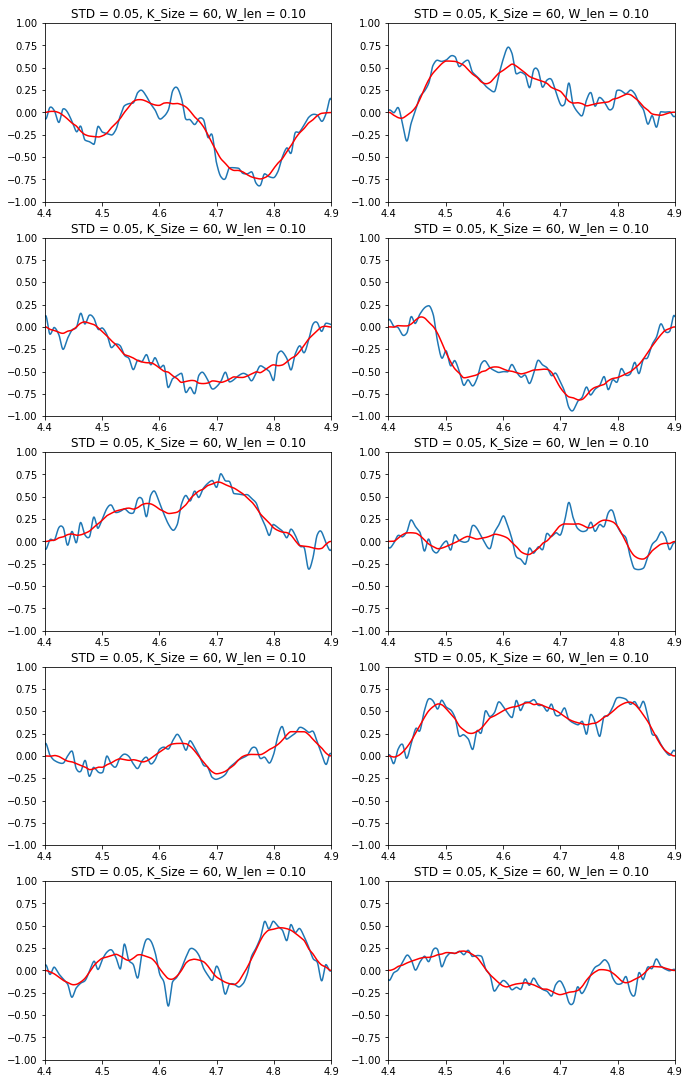

STD = 0.1


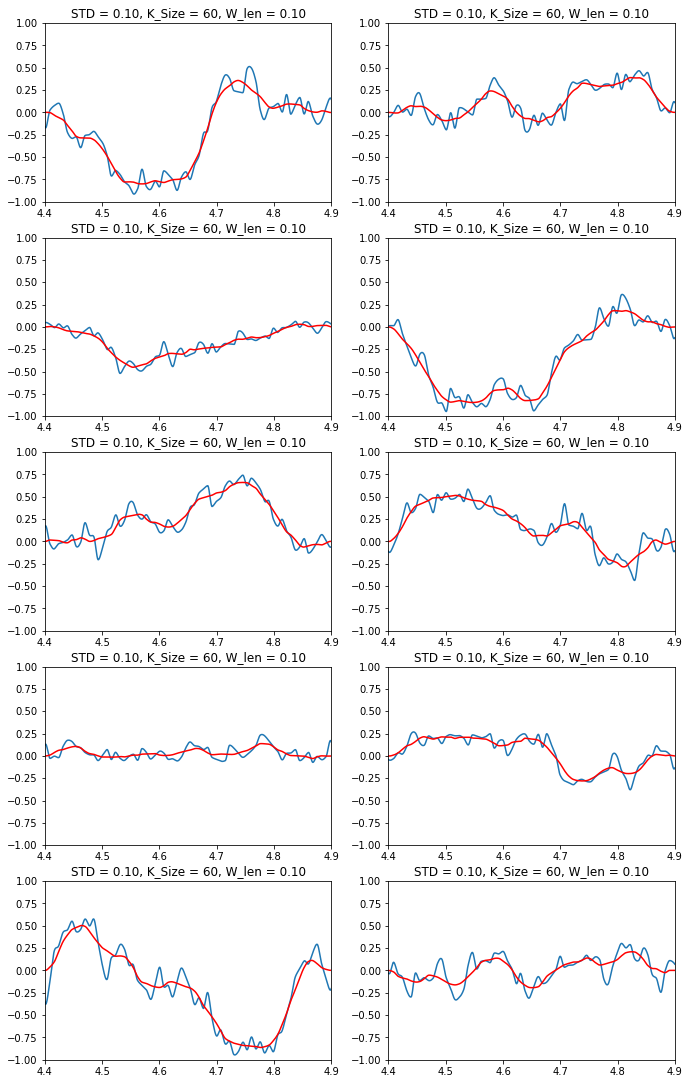

STD = 0.15


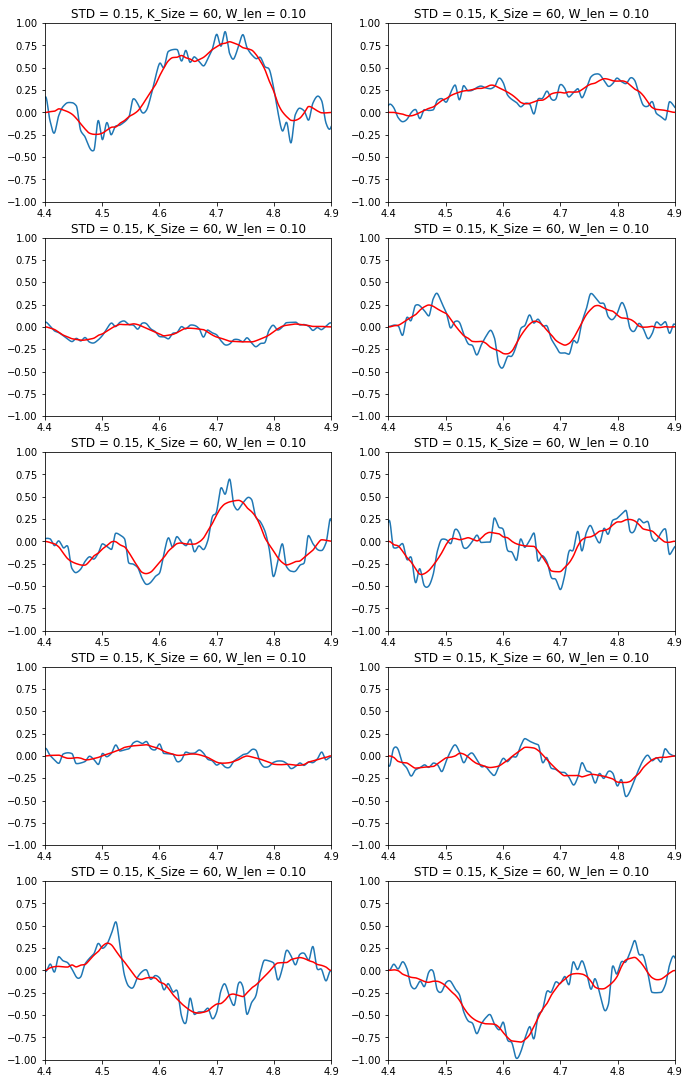

STD = 0.2


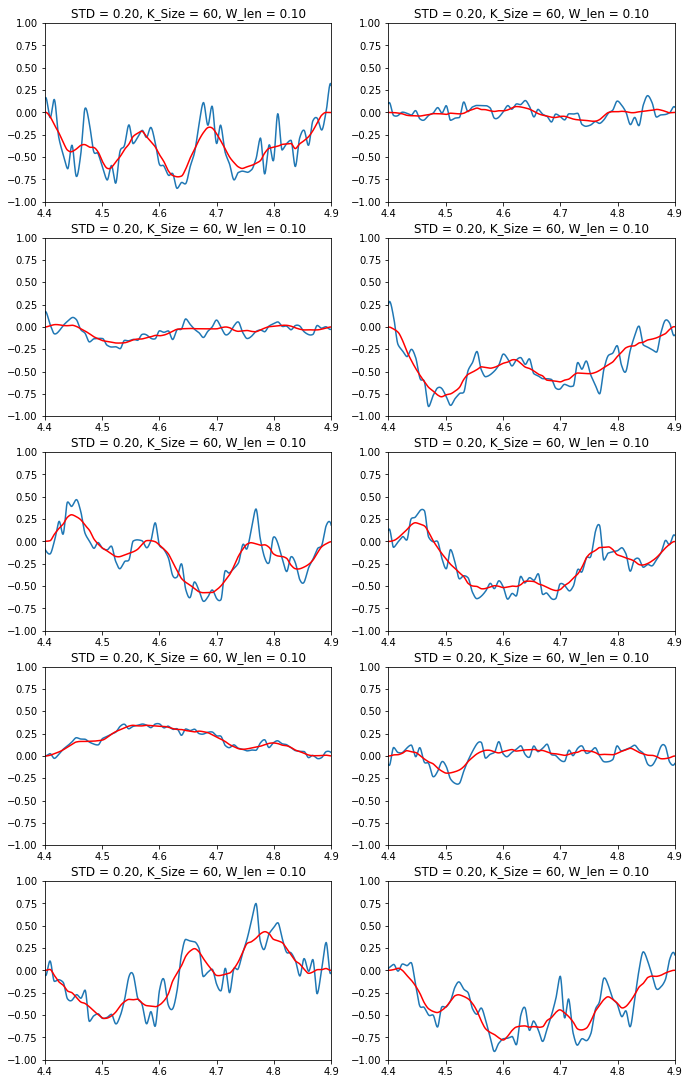

In [80]:
std = [0.05, 0.10, 0.15, 0.20]
params = copy.copy(cfg)
for i, sd in enumerate(std):
    print('STD = {}'.format(sd))
    params['std'].fill_(sd)
    baseline, smoothed, raw_baseline = generate(params, ppm, ppm_cropped)
    
    plot(baseline, smoothed, sd, params['windows'], params['length'], ppm_cropped, cropped=crop_range)

### Smoothing Kernel
This cell generates various plots showing the effect of different smoothing kernel lengths given a fixed std value

STD = 0.1
Window Length: 0.05


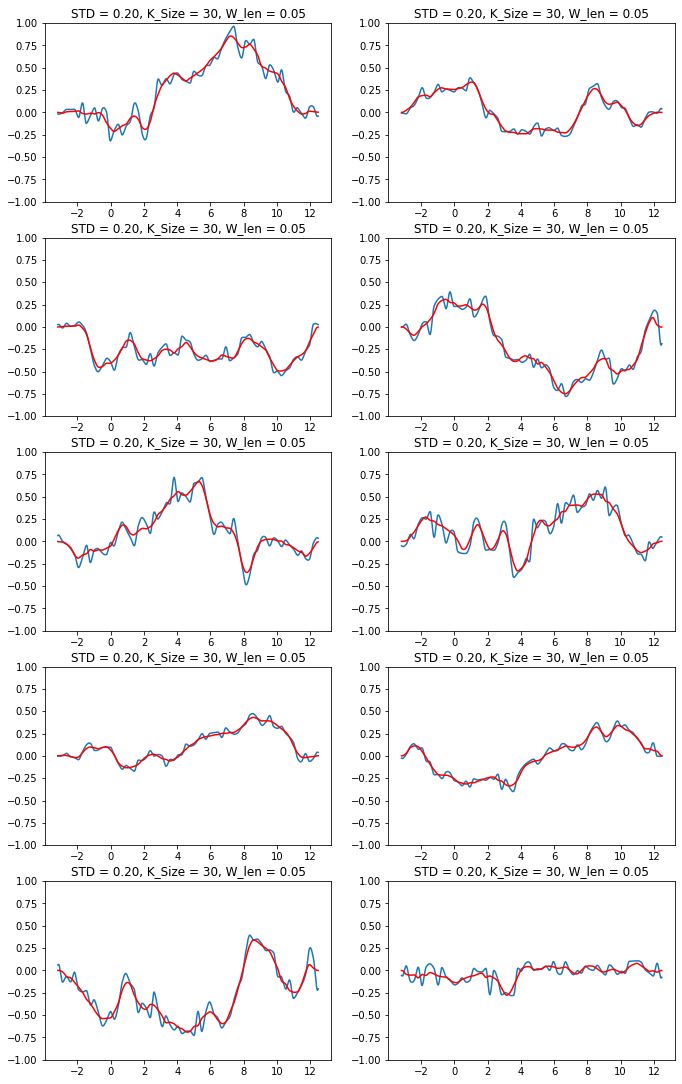

Window Length: 0.15


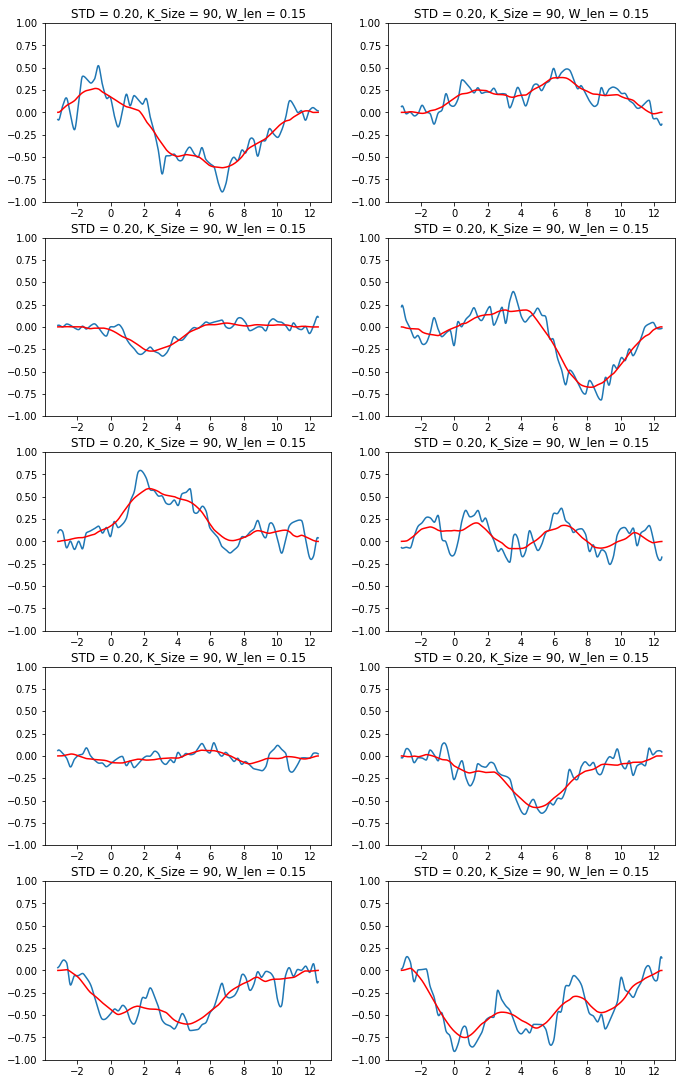

Window Length: 0.25


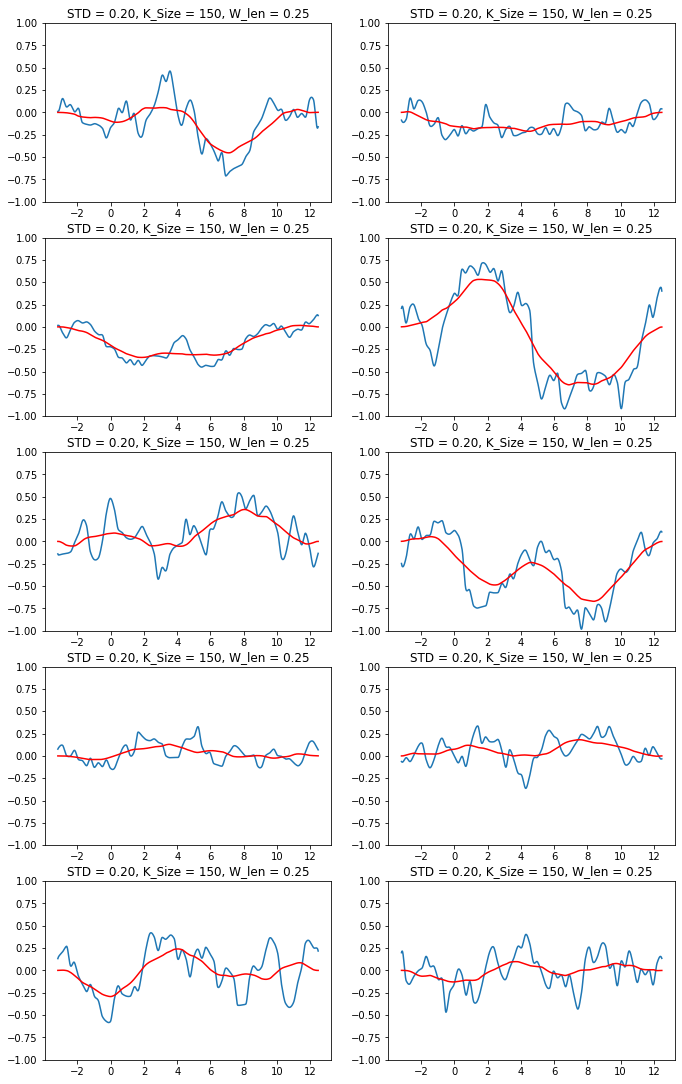

In [82]:
std = 0.10
params = copy.copy(cfg)
params['std'].fill_(std)
# print('STD = {}'.format(std))
# window = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
window = [0.05, 0.15, 0.25]
for i, wnd in enumerate(window):
    print('STD = {}, Window Length: {}'.format(std,wnd))
    params['windows'].fill_(wnd)
    baseline, smoothed, raw_baseline = generate(params, ppm, ppm_cropped)
    
    plot(baseline, smoothed, sd, params['windows'], params['length'], ppm, ppm_cropped)

### Point Density

This section generates various plots showing the effect of different point density values on the random walk while keeping the $std$ fixed and presenting results using two different kernel sizes for the smoothing.

Point Density: 128, Window Length = [0.1, 0.3], STD = 0.1


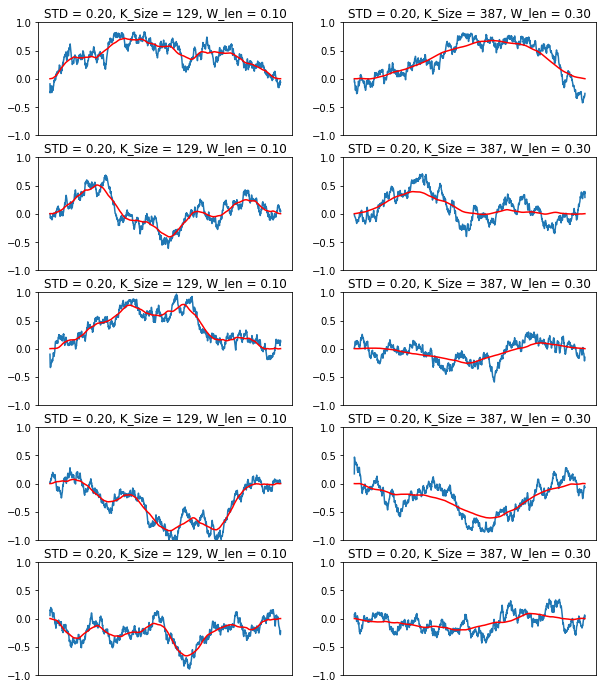

Point Density: 256, Window Length = [0.1, 0.3], STD = 0.1


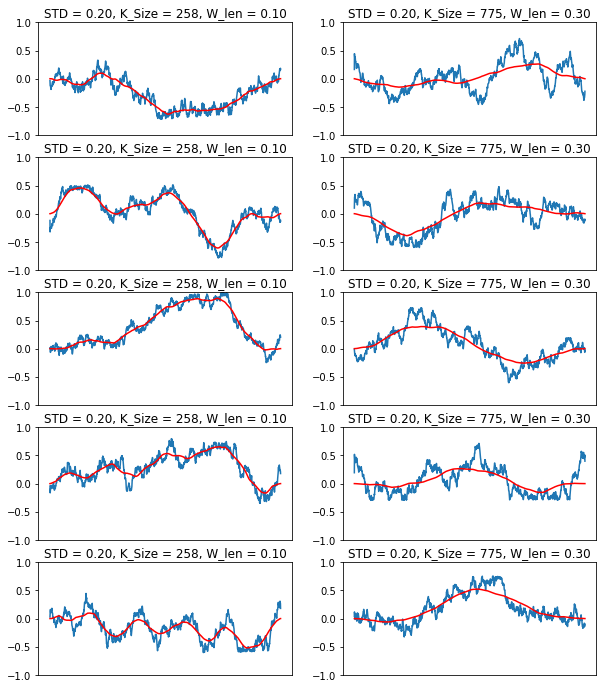

Point Density: 512, Window Length = [0.1, 0.3], STD = 0.1


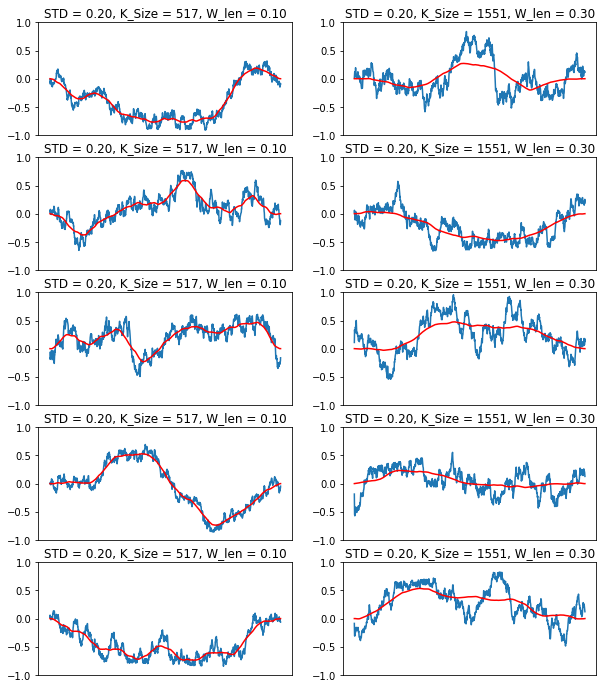

Point Density: 1024, Window Length = [0.1, 0.3], STD = 0.1


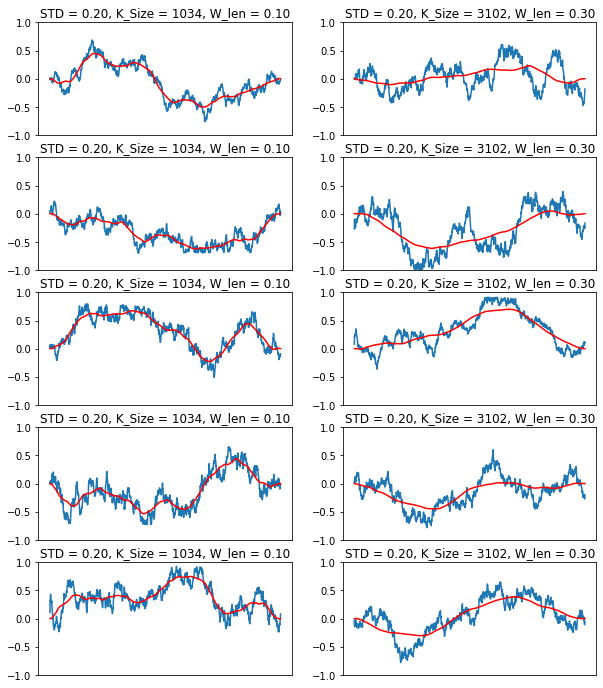

Point Density: 2048, Window Length = [0.1, 0.3], STD = 0.1


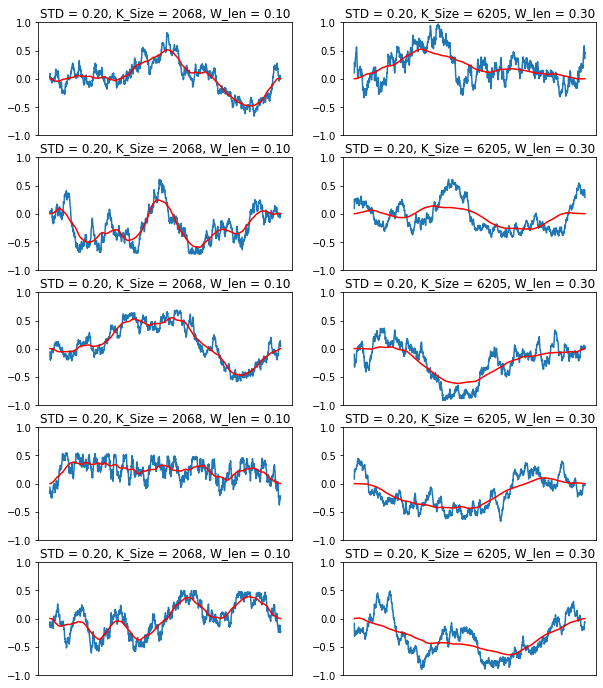

In [39]:
pt_density = [128, 256, 512, 1024, 2048]
std = 0.10
wnd = [0.1, 0.3]
params = copy.copy(cfg)
params['std'].fill_(std)
params['windows'].fill_(wnd[0])
for i in range(1,10,2): 
    params['windows'][i,...].fill_(wnd[1])

for i, ptd in enumerate(pt_density):
    print('Point Density: {}, Window Length = {}, STD = {}'.format(ptd, wnd, std))
    length = round((params['ppm_range'][1]-params['ppm_range'][0]) * ptd)
    params['length'] = length
    baseline, smoothed, raw_baseline = generate(params, ppm, ppm_cropped)
    
    plot(baseline, smoothed, sd, params['windows'], params['length'], ppm, ppm_cropped)

### Incorporating the offsets into the spectra

The offsets are simulated with specified ppm ranges and point densities. In order to add them to the spectra, they need to be resampled to the original ppm range and point density of the basis functions. Additionally, to increase variability in the outputs, the starting and ending heights are randomly selected. In order to enfore more natural looking baselines when considering the entire spectrum, they have to be adjusted so as not to have unrealistic hard start and end points.

This section shows how the spectra look with and without this adjustment.

With the original trend lines still included


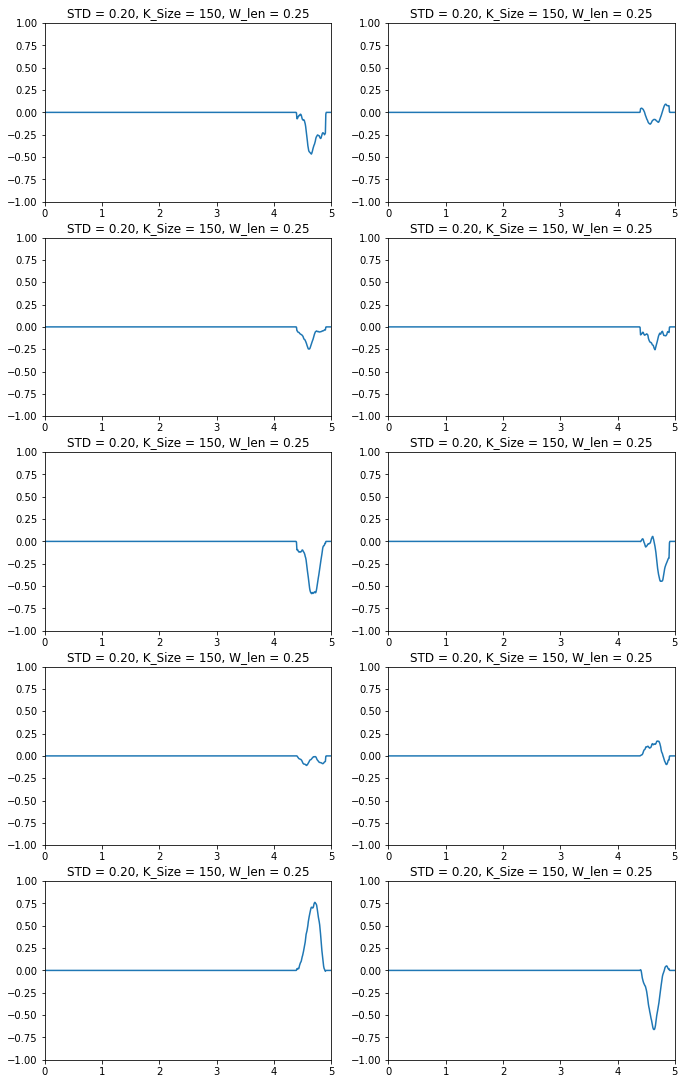

With the original trend lines removed


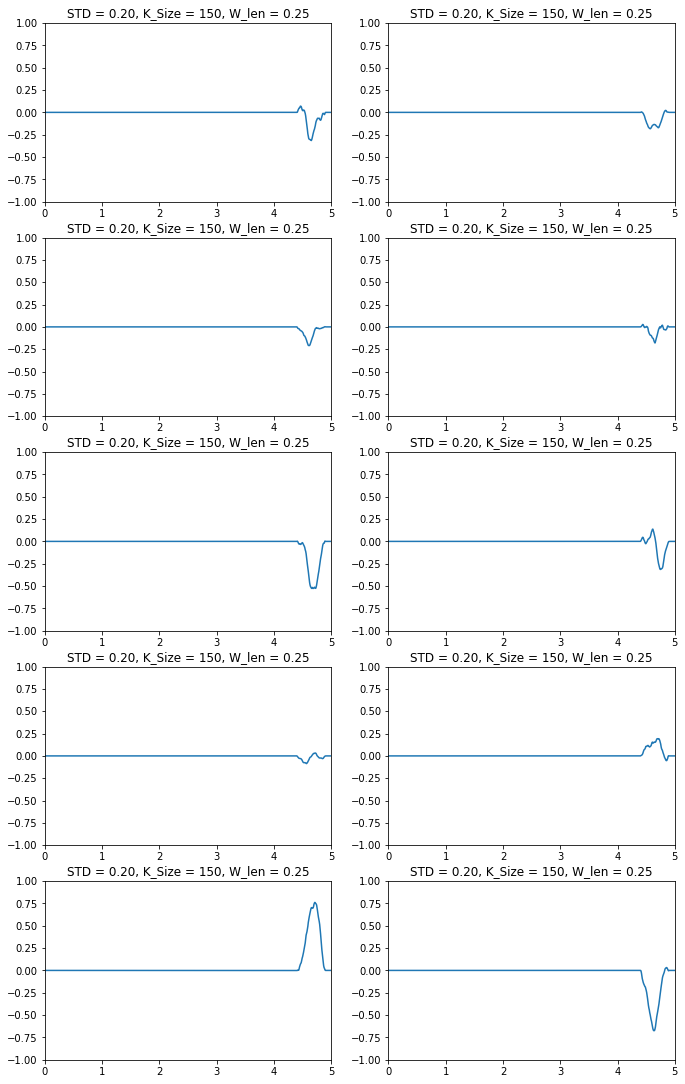

In [84]:
baseline, smoothed, raw_baseline, trend = generate(cfg, ppm, ppm_cropped, trendlines=True)
print('With the original trend lines still included')
plot(raw_baseline+trend, None, sd, params['windows'], params['length'], ppm, cropped=[0,5])

print('With the original trend lines removed')
plot(raw_baseline, None, sd, params['windows'], params['length'], ppm, cropped=[0,5])

### Effect of the Hilbert Transform

FIDs are complex, meaning they have real and imaginary components. In order to acurrately simulate spectra, the components need to be complex, including the baseline and residual water. In order to acheive this, the Hilbert Transform is used. Once the real components have been simulated, the Hilbert transform can then generate a corresponding imaginary component. The following code will plot the outputs to visualize this second component.

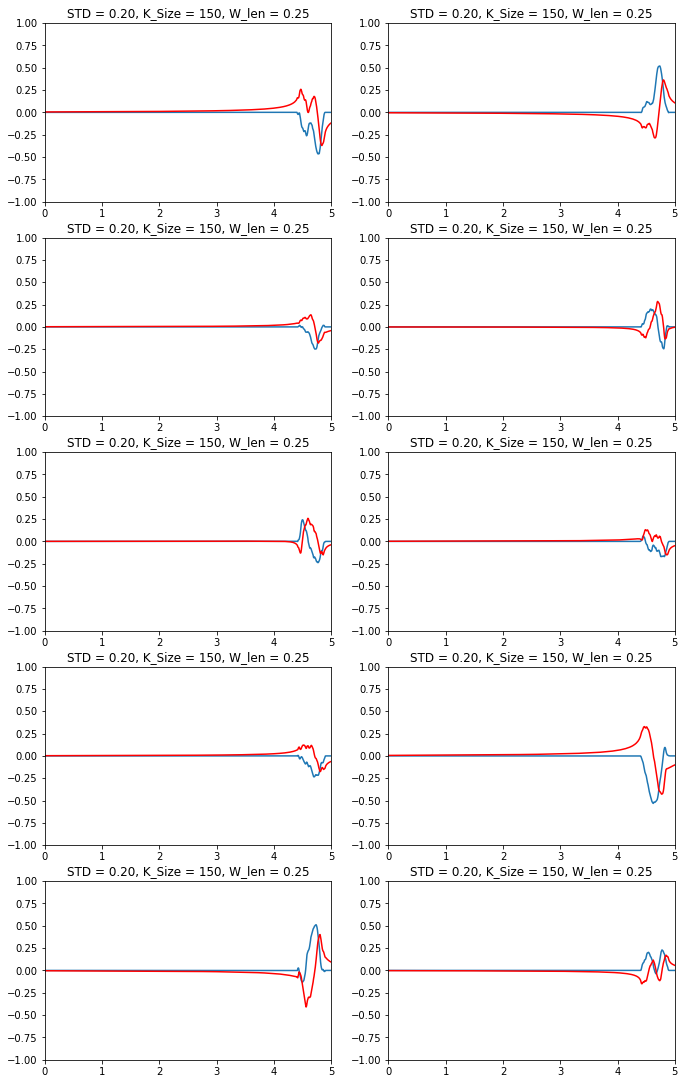

In [88]:
baseline, smoothed, raw_baseline = generate(cfg, ppm, ppm_cropped)
# Legend: real (blue) and imaginary (red)
plot(raw_baseline[:,0,:].unsqueeze(1), raw_baseline[:,1,:].unsqueeze(1), 
#      sd, params['windows'], params['length'], ppm, ppm_cropped) # baseline
     sd, params['windows'], params['length'], ppm, cropped=[0,5]) # residual water

### The Fourier Transform

While MRS-Sim generates spectra, the NIfTI-MRS outputs are are exported as FIDs for seamless use with fitting algorithms. This section shows what the time-domain FIDs look like.

You'll notice that there are tails at both ends of the FIDs which is not usual with MRS data. This is still being investigated. These tails do not affect frequency-domain fitting program, but it is possible that they may cause issues with time-domain fitting. These occur with both the residual water and baseline simulations. As long as apodization is not applied, there should be no other issues. We hope to resolve this issue soon.

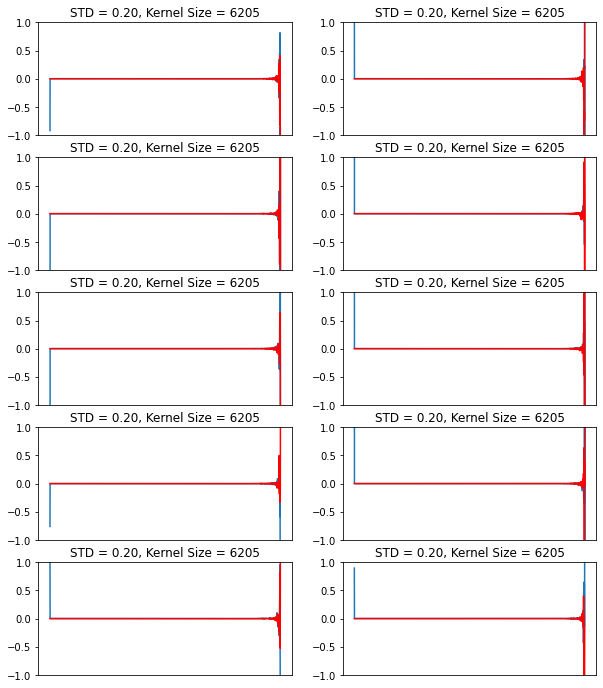

In [18]:
fid = inv_Fourier_Transform(raw_baseline)
coeff=10
plot(fid[:,0,:].unsqueeze(1)*coeff, fid[:,1,:].unsqueeze(1)*coeff, 
     sd, params['windows'], params['length'], ppm, ppm_cropped)

In [89]:
for i in range(0): print(i)

Finally, this last cell shows the variety of baselines that can be generated when randomly sampling all variables

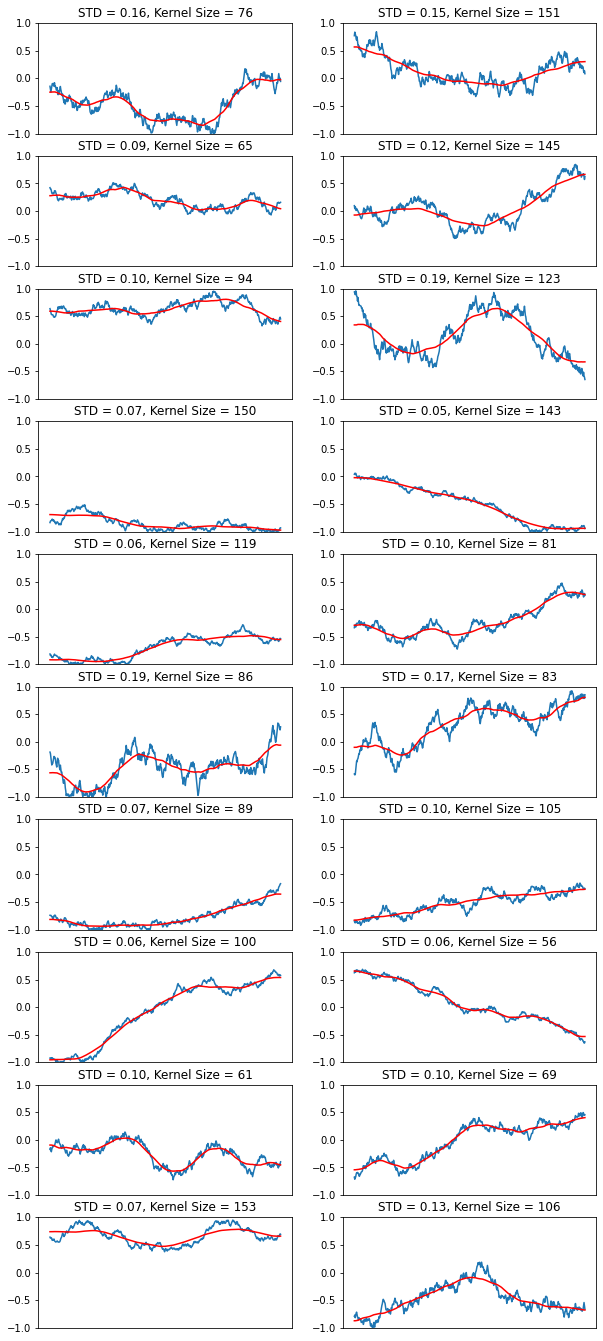

In [15]:
N = 20
start = torch.zeros(N,1,1).uniform_(-1,1)
end = torch.zeros(N,1,1).uniform_(-1,1)
std3 = torch.zeros(N,1,1).uniform_(0.05,0.2)
length = 512
raw_baselines = bounded_random_walk(start, end, std3, -1, 1, length)

windows = torch.ones_like(start).uniform_(0.1,0.3)
smooth_baselines = batch_smooth(raw_baselines, windows)

plot(raw_baselines, smooth_baselines, std3, windows, length)